In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
# Data source: https://www.kaggle.com/datasets/sushobhitlutade/inventorysupply-chain-managementscm-superstore/data?select=Brand.csv
# US holiday 2004-2021 data: https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021?select=US+Holiday+Dates+%282004-2021%29.csv

In [22]:
#download data
# https://drive.google.com/file/d/1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7/view?usp=sharing
# https://drive.google.com/file/d/1gevzcsdgYnpcMVUJBhOe3z6QsIPK7GJZ/view?usp=sharing

dwn_url='https://drive.google.com/uc?id='
# df_id = dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7"
df_trans = pd.read_csv(dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7") #transactions data
df_prod = pd.read_csv(dwn_url+"1gevzcsdgYnpcMVUJBhOe3z6QsIPK7GJZ") #products data

#deletes white spaces on column tittles
df_trans.columns = [col.strip() for col in df_trans.columns]
df_prod.columns = [col.strip() for col in df_prod.columns]

#transforms date column to datetime format
df_trans["Transaction_date"] = pd.to_datetime(df_trans["Transaction_date"], format = "%Y-%m-%d")

#Clean transaction table, delete unnecessary columns (Payment_Method, Customer_Cart, Cashier)
df_trans = df_trans.drop(columns=['Payment_Method', 'CustomerCart_CustomerID','Cashier_CashierID'])

#Clean data to show only 2014-2017 data
#df_trans=df_trans[df_trans["Transaction_date"].dt.year <= 2017]


In [23]:
df_trans.head()

,Transaction_date,Quantity,Subtotal,Taxes,DiscountPrice,TotalAmount,Products_ProductID
0,2016-11-11,2,261.96,11.46,78.59,273.42,FUR-BO-10001798
1,2016-11-11,3,512.36,22.42,153.71,534.77,FUR-CH-10000454
2,2016-06-16,2,14.62,0.91,0.00,15.53,OFF-LA-10000240
3,2015-10-18,5,957.58,41.89,287.27,999.47,FUR-TA-10000577
4,2015-10-18,2,27.96,1.57,2.80,29.53,OFF-ST-10000760


In [24]:
#create column for Units Sold
df_trans['Units_Sold'] = df_trans['Quantity']
#df_trans.rename(columns={'Quantity': 'Units_Sold'}, inplace=True)

#delete column named 'Quantity' for better column lableling/understanding
df_trans = df_trans.drop(columns=['Quantity'])

#add columns to Transaction Table
df_trans['Cat-SubCat_ID']= df_trans['Products_ProductID'].str[:6]
df_trans['Cat_ID']= df_trans['Products_ProductID'].str[:3] #first 3 letters of Category ID
df_trans['SubCat_ID']= df_trans['Products_ProductID'].str[4:6] #first 2 letters of SubCategory ID
#df_trans['Quarter'] = df_trans['Transaction_date'].dt.quarter
df_trans['Year']= df_trans['Transaction_date'].dt.year
#df_trans['Month']= df_trans['Transaction_date'].dt.month
#df_trans['Day_of_Year']= df_trans['Transaction_date'].dt.day_of_year
df_trans['Year-Month'] = df_trans['Transaction_date'].dt.to_period('M')
#df_trans['Day_of_the_Week']= df_trans['Transaction_date'].dt.day_name()


In [ ]:
df_trans.head()

,Transaction_date,Subtotal,Taxes,DiscountPrice,TotalAmount,Products_ProductID,Units_Sold,Cat-SubCat_ID,Cat_ID,SubCat_ID,Year,Year-Month
0,2016-11-11,261.96,11.46,78.59,273.42,FUR-BO-10001798,2,FUR-BO,FUR,BO,2016,2016-11
1,2016-11-11,512.36,22.42,153.71,534.77,FUR-CH-10000454,3,FUR-CH,FUR,CH,2016,2016-11
2,2016-06-16,14.62,0.91,0.00,15.53,OFF-LA-10000240,2,OFF-LA,OFF,LA,2016,2016-06
3,2015-10-18,957.58,41.89,287.27,999.47,FUR-TA-10000577,5,FUR-TA,FUR,TA,2015,2015-10
4,2015-10-18,27.96,1.57,2.80,29.53,OFF-ST-10000760,2,OFF-ST,OFF,ST,2015,2015-10


In [ ]:
subcat_per_year = df_trans.groupby(['Cat-SubCat_ID','Year']).Units_Sold.sum().reset_index()
#subcat_per_year['No. Years sold'] = items_per_year.groupby(['Cat-SubCat_ID']).transform('size')

subcat_per_year.sort_values(['Units_Sold'], ascending=False).head(50).reset_index().head()

,index,Cat-SubCat_ID,Year,Units_Sold
0,32,OFF-BI,2017,2051
1,51,OFF-PA,2017,1706
2,31,OFF-BI,2016,1615
3,50,OFF-PA,2016,1363
4,30,OFF-BI,2015,1195


In [25]:
# Instead of one item, we choose one sub-catagory 'OFF-BI'.

# df_subcat = df_trans.query("'Cat-SubCat_ID' == 'OFF-BI'").sort_values(["Transaction_date"], axis=0, ascending=[True])

df_subcat = df_trans.query("`Cat-SubCat_ID` == 'OFF-BI'")
df_subcat = df_subcat.sort_values(["Transaction_date"], axis=0, ascending=[True])

df_subcat

,Transaction_date,Subtotal,Taxes,DiscountPrice,TotalAmount,Products_ProductID,Units_Sold,Cat-SubCat_ID,Cat_ID,SubCat_ID,Year,Year-Month
741,2014-01-08,5.31,0.33,0.00,5.64,OFF-BI-10004094,2,OFF-BI,OFF,BI,2014,2014-01
7475,2014-01-10,41.44,2.33,4.14,43.77,OFF-BI-10004632,2,OFF-BI,OFF,BI,2014,2014-01
7661,2014-01-12,31.29,1.96,0.00,33.25,OFF-BI-10003708,7,OFF-BI,OFF,BI,2014,2014-01
766,2014-01-15,11.28,0.71,0.00,11.99,OFF-BI-10004187,3,OFF-BI,OFF,BI,2014,2014-01
972,2014-01-18,37.18,2.09,3.72,39.27,OFF-BI-10001575,2,OFF-BI,OFF,BI,2014,2014-01
...,...,...,...,...,...,...,...,...,...,...,...,...
7485,2018-01-02,15.54,0.97,0.00,16.51,OFF-BI-10004040,5,OFF-BI,OFF,BI,2018,2018-01
1297,2018-01-03,41.44,2.33,4.14,43.77,OFF-BI-10004632,2,OFF-BI,OFF,BI,2018,2018-01
908,2018-01-03,39.58,2.23,3.96,41.81,OFF-BI-10003684,3,OFF-BI,OFF,BI,2018,2018-01
1296,2018-01-03,10.43,0.65,0.00,11.08,OFF-BI-10002103,2,OFF-BI,OFF,BI,2018,2018-01


In [26]:
df_subcat.dtypes

Transaction_date      datetime64[ns]
Subtotal                     float64
Taxes                        float64
DiscountPrice                float64
TotalAmount                  float64
Products_ProductID            object
Units_Sold                     int64
Cat-SubCat_ID                 object
Cat_ID                        object
SubCat_ID                     object
Year                           int32
Year-Month                 period[M]
dtype: object

In [27]:
df_subcat.isna().sum()

Transaction_date      0
Subtotal              0
Taxes                 0
DiscountPrice         0
TotalAmount           0
Products_ProductID    0
Units_Sold            0
Cat-SubCat_ID         0
Cat_ID                0
SubCat_ID             0
Year                  0
Year-Month            0
dtype: int64

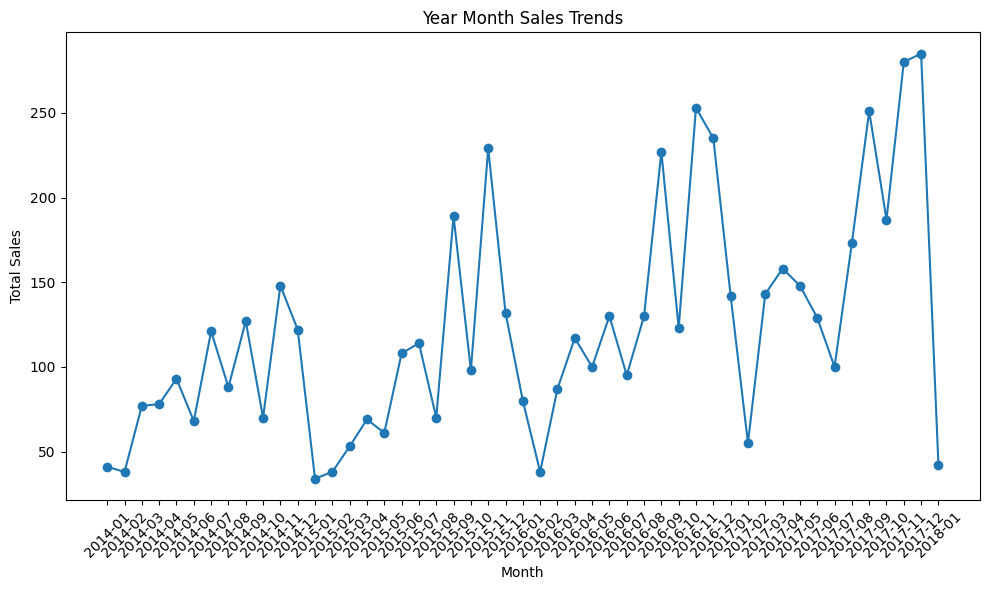

In [28]:
# Group data and reset index to get a DataFrame
df_grouped = df_subcat.groupby(['Year-Month'])['Units_Sold'].sum().reset_index()

# Convert 'Year-Month' to string for plotting
df_grouped['Year-Month'] = df_grouped['Year-Month'].astype(str)

# Plot the line graph with correct labels and title
plt.figure(figsize=(10, 6))  # Adjust figure size as desired
plt.plot(df_grouped['Year-Month'], df_grouped['Units_Sold'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Year Month Sales Trends')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [ ]:
# https://www.tutorialspoint.com/time_series/time_series_arima.htm

Auto-regressive moving average (ARMA) model

And the statistical models we have studied so far assume the time series to be stationary, therefore, we can include a pre-processing step of differencing the time series to make it stationary. Now, it is important for us to find out whether the time series we are dealing with is stationary or not.

Various methods to find the stationarity of a time series are looking for seasonality or trend in the plot of time series, checking the difference in mean and variance for various time periods, Augmented Dickey-Fuller (ADF) test, KPSS test, Hurst’s exponent etc.

Let us see whether the ‘units_sold’ variable of our dataset is a stationary time series or not using ADF test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_subcat['Units_Sold'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Statistic: -38.522869
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


Now that we have run the ADF test, let us interpret the result. First we will compare the ADF Statistic with the critical values, a lower critical value tells us the series is most likely non-stationary. Next, we see the p-value. A p-value greater than 0.05 also suggests that the time series is non-stationary.

Alternatively, p-value less than or equal to 0.05, or ADF Statistic less than critical values suggest the time series is stationary.

Hence, the time series we are dealing with is already stationary. In case of stationary time series, we set the ‘d’ parameter as 0.


In [ ]:
# Split the data into features and target variable
X = df_subcat[['Year-Month']]
y = df_subcat['Units_Sold']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train.values, order=(5, 0, 2))
model_fit = model.fit()

In [ ]:
predictions = model_fit.predict(len(y_test))
test_ = pandas.DataFrame(y_test)
test_['predictions'] = predictions#[0:1871]

NameError: name 'pandas' is not defined

In [ ]:
# https://drive.google.com/file/d/1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK/view?usp=sharing
dwn_url='https://drive.google.com/uc?id='
#df_id = dwn_url+"1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK"
df_holiday = pd.read_csv(
    dwn_url+"1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK"
)

In [ ]:
df_holiday

In [ ]:
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])

In [ ]:
df_holiday.info()

In [ ]:
start_date = '2014-01-01'
end_date = '2018-12-31'

df_hld = df_holiday[(df_holiday['Date'] >= start_date) & (df_holiday['Date'] <= end_date)]

In [ ]:
df_hld

In [ ]:
df_hld['Holiday'].value_counts()